<a href="https://colab.research.google.com/github/Faisal-NSU/CSE465/blob/main/Making%20pickle%20obvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys


def plot_images(images, nrows = None, ncols = None, figsize = None, ax = None, 
                axis_style = 'on', bgr2rgb = True):
    '''
    Plots a given list of images and returns axes.Axes object
    
    Parameters
    -----------
    images: list
            A list of images to plot
            
    nrows: int
           Number of rows to arrange images into
    
    ncols: int
           Number of columns to arrange images into
    
    figsize: tuple
             Plot size (width, height) in inches
           
    ax: axes.Axes object
        The axis to plot the images on, new axis will be created if None
        
    axis_style: str
                'off' if axis are not to be displayed
    '''
    N = len(images)
    if not isinstance(images, (list, np.ndarray)):
        raise AttributeError("The images parameter should be a list of images, "
                             "if you want to plot a single image, pass it as a "
                             "list of single image")

    # Setting nrows and ncols as per parameter input
    if nrows is None:
        if ncols is None:
            nrows = N
            ncols = 1
        else:
            nrows = int(np.ceil(N / ncols))
    else:
        if ncols is None:
            ncols = int(np.ceil(N / nrows))
    
    if ax is None:
        _, ax = plt.subplots(nrows, ncols, figsize = figsize)
    
    if len(images) == 1:
        if bgr2rgb == True:
            images[0] = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
    
        ax.imshow(images[0])
        ax.axis(axis_style)
        
        return ax
    
    else:
        for i in range(nrows):
            for j in range(ncols):
                if (i * ncols + j) < N:
                    img = images[i * ncols + j]
                    
                    if bgr2rgb == True:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    # For this condition, ax is a 2d array else a 1d array
                    if nrows >1 and ncols > 1: 
                        ax[i][j].imshow(img)
                    
                    else:
                        ax[i + j].imshow(img)
                
                if nrows > 1 and ncols > 1:
                    ax[i][j].axis(axis_style)
                else:
                    ax[i + j].axis(axis_style)
        
        return ax


def drawProgressBar(current, total, string = '', barLen = 20):
    '''
    Draws a progress bar, something like [====>    ] 20%
    
    Parameters
    ------------
    current: int/float
             Current progress
    
    total: int/float
           The total from which the current progress is made
             
    string: str
            Additional details to write along with progress
    
    barLen: int
            Length of progress bar
    '''
    percent = current/total
    arrow = ">"
    if percent == 1:
        arrow = ""
    # Carriage return, returns to the begining of line to owerwrite
    sys.stdout.write("\r")
    sys.stdout.write("Progress: [{:<{}}] {}/{}".format("=" * int(barLen * percent) + arrow, 
                                                         barLen, current, total) + string)
    sys.stdout.flush()

# Imports


In [2]:
import IPython.display as ipd
import librosa
import librosa.display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Drive Mount


In [7]:
!gdown --id 1k-afEJdwz5Tf4-bsuKOJzP7xn-KQTlkM

Downloading...
From: https://drive.google.com/uc?id=1k-afEJdwz5Tf4-bsuKOJzP7xn-KQTlkM
To: /content/SUBESCO.zip
100% 1.65G/1.65G [00:10<00:00, 155MB/s]


In [8]:
import zipfile
dataset_directory = '/content/SUBESCO.zip'
zip_ref = zipfile.ZipFile(dataset_directory, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [9]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

'Tesla K80'

# Preprocess


In [ ]:
df = pd.read_csv(ANNOTATIONS_FILE)
df

,filename,name,gender,label,label_id
0,F_01_OISHI_S_10_ANGRY_1.wav,OISHI,F,ANGRY,0
1,F_01_OISHI_S_10_ANGRY_2.wav,OISHI,F,ANGRY,0
2,F_01_OISHI_S_10_ANGRY_3.wav,OISHI,F,ANGRY,0
3,F_01_OISHI_S_10_ANGRY_4.wav,OISHI,F,ANGRY,0
4,F_01_OISHI_S_10_ANGRY_5.wav,OISHI,F,ANGRY,0
...,...,...,...,...,...
6995,M_10_EVAN_S_9_SURPRISE_1.wav,EVAN,M,SURPRISE,6
6996,M_10_EVAN_S_9_SURPRISE_2.wav,EVAN,M,SURPRISE,6
6997,M_10_EVAN_S_9_SURPRISE_3.wav,EVAN,M,SURPRISE,6
6998,M_10_EVAN_S_9_SURPRISE_4.wav,EVAN,M,SURPRISE,6


# Getting Features


## Define Functions

In [10]:
def get_fixed_audio_len(wav, sr, audio_len):
    '''
    Converts a time-series audio to a fixed length either by padding or trimming
    
    Parameters
    -------------
    wav: Audio time-series
    
    sr: Sample rate
    
    audio_len: The fixed audio length needed in seconds
    '''
    if wav.shape[0] < audio_len * sr:
        wav = np.pad(wav, int(np.ceil((audio_len * sr - wav.shape[0])/2)), mode = 'reflect')
    wav = wav[:audio_len * sr]
    
    return wav

def get_melspectrogram_db(wav, sr, audio_len = 4, n_fft = 2048, hop_length = 512, 
                          n_mels = 128, fmin = 20, fmax = 8300, top_db = 80):
    '''
    Decomposes the audio sample into different frequencies using fourier transform 
    and converts frequencies to mel scale and amplitude to decibel scale.
    
    Parameters
    -------------------
    wav: Audio time-series
    
    sr: Sample rate
    
    audio_len: The fixed length of audio in seconds
    
    n_fft: Length of the Fast Fourier Transform window
    
    hop_length: Number of samples between successive frames
    
    n_mels: Number of mel filters, which make the height of spectrogram image
    
    fmin: Lowest frequency
    
    fmax: Heighest frequency
    
    top_db: Threashold of the decibel scale output
    '''
    wav = get_fixed_audio_len(wav, sr, audio_len)
        
    spec = librosa.feature.melspectrogram(wav, sr = sr, n_fft = n_fft, hop_length = hop_length, 
                                          n_mels = n_mels, fmin = fmin, fmax = fmax)
    
    spec = librosa.power_to_db(spec, top_db = top_db)
    return spec

def spec_to_image(spec):
    '''
    Converts the spectrogram to an image
    
    Parameters
    -------------
    spec: Spectrogram
    '''
    eps=1e-6
    
    # Z-score normalization
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    
    # Min-max scaling
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    
    return spec_scaled

## Splitting Val

# Training an Artificial Neural Network on time-series audio data

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

# Defining dataset batch size
BATCH_SIZE = 32

def load_data(df, id_col, label_col = None, data_path = './', audio_len = 4):
    '''
    Loads the audio time-series data
    
    Parameters
    -------------
    df: The dataframe that contains the file name and corresponding label
    
    id_col: The column name that contains the file name
    
    label_col: The column name that contains the label
    '''
    audio_time_series = []
    sample_rates = []
    labels = []
    
    tot = len(df)
    curr = 0
    
    for idx in df.index:
        try:
            file_name = str(df['filename'][idx]) 
            
            temp = data_path + file_name
            wav, sr = librosa.load(str(temp))
            
            wav = get_fixed_audio_len(wav, sr, audio_len)
    
            audio_time_series.append(wav)
            sample_rates.append(sr)
            
            if label_col is not None:
                labels.append(df[label_col][idx])
            
            curr += 1
            drawProgressBar(curr, tot, barLen = 40)
        
        except KeyboardInterrupt:
            print('KeyBoardInterrupt')
            break
        
        except Exception:
            print("Couldn't read file", df[id_col][idx])
            curr += 1
            
    print('\n')
    return np.stack(audio_time_series, axis = 0), np.array(sample_rates), np.array(labels)

In [12]:
TRAIN_CSV = '/content/SUBESCO/train/train.csv'
TEST_CSV = '/content/SUBESCO/test/test.csv'
VALID_CSV = '/content/SUBESCO/valid/valid.csv'

TRAIN_PATH = '/content/SUBESCO/train/'
TEST_PATH = '/content/SUBESCO/test/'
VALID_PATH = '/content/SUBESCO/valid/'


In [28]:
import time
import pandas as pd
start_time = time.time()

#train_time_series, train_sr, train_labels = load_data(train_df, 'filename', 'label_id', AUDIO_DIR)

val_time_series, _, val_labels = load_data(pd.read_csv(VALID_CSV), 'filename', 'label_id', VALID_PATH)

test_time_series, _, test_labels = load_data(pd.read_csv(TEST_CSV), 'filename', 'label_id', TEST_PATH)

print("--- %s seconds ---" % (time.time() - start_time))

Progress: [>                                       ] 15/700KeyBoardInterrupt


Progress: [=================>                      ] 617/1400KeyBoardInterrupt


--- 161.78716015815735 seconds ---


In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
#saving pickle
import bz2
import pickle

testDic = { 'test_time_series': test_time_series, 'test_labels': test_labels }

filename = 'testDic'
outfile = open(filename,'wb')

pickle.dump(testDic,outfile)
outfile.close()

In [23]:
infile = open(filename,'rb')
valDic = pickle.load(infile)
infile.close()

In [25]:
valDic['val_labels'].shape

(700,)

In [27]:
!cp -r '/content/valDic' /content/gdrive/MyDrive/CSE465

In [ ]:
# Convert numpy arrays to torch tensors
train_time_series = torch.from_numpy(train_time_series)
train_labels = torch.from_numpy(train_labels).long()

val_time_series = torch.from_numpy(val_time_series)
val_labels = torch.from_numpy(val_labels).long()

# Create data loaders
train_time_series = data_utils.TensorDataset(train_time_series, train_labels)
train_loader = data_utils.DataLoader(train_time_series, batch_size = BATCH_SIZE, shuffle = True)

val_time_series = data_utils.TensorDataset(val_time_series, val_labels)
val_loader = data_utils.DataLoader(val_time_series, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
# Defining training parameters
LEARNING_RATE = 0.001
EPOCHS = 10
NUM_CLASSES = len(classes)
N_FEATURES = train_time_series[0][0].shape[0]
N_FEATURES

88200

In [ ]:
# Defining our neural network architecture
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        # Layer 1 with 1024 neurons
        self.fc1 = nn.Linear(in_features = N_FEATURES, out_features = 1024)
        
        # Layer 2 with 512 neurons
        self.fc2 = nn.Linear(in_features = 1024, out_features = 512)
        
        # Layer 3 with 128 neurons
        self.fc3 = nn.Linear(in_features = 512, out_features = 128)
        
        # Layer 4, output layer
        self.fc4 = nn.Linear(in_features = 128, out_features = NUM_CLASSES)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [ ]:
# Defining loss and optimizer

net = NeuralNet()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = LEARNING_RATE)

In [ ]:
num_train_batches = len(train_loader)
loss_hist = []
acc_hist = []

for epoch in range(EPOCHS):
    print("Epoch " + str(epoch + 1) + ":")
    
    for i, batch in enumerate(train_loader):
        # batch is a tuple of input data and labels
        inputs, labels = batch
        
        # Running forward pass
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Measuring Accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs, dim = 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct/total
        
        # Printing progress
        drawProgressBar((i+1), num_train_batches, 
                              '\t loss: {:.4f} \t acc: {:.4f}'.format(round(loss.item(), 4), round(accuracy, 4)))
    
    print('\n\n')
    acc_hist.append(accuracy)
    loss_hist.append(loss.item())

Epoch 1:
Progress: [====================] 175/175	 loss: 1.9174 	 acc: 0.2500


Epoch 2:
Progress: [====================] 175/175	 loss: 1.7544 	 acc: 0.3750


Epoch 3:
Progress: [====================] 175/175	 loss: 1.2890 	 acc: 0.5938


Epoch 4:
Progress: [====================] 175/175	 loss: 0.2571 	 acc: 0.9375


Epoch 5:
Progress: [====================] 175/175	 loss: 0.2405 	 acc: 0.8750


Epoch 6:
Progress: [====================] 175/175	 loss: 0.0288 	 acc: 1.0000


Epoch 7:
Progress: [====================] 175/175	 loss: 0.0326 	 acc: 1.0000


Epoch 8:
Progress: [====================] 175/175	 loss: 0.0963 	 acc: 0.9688


Epoch 9:
Progress: [====================] 175/175	 loss: 0.2587 	 acc: 0.9375


Epoch 10:
Progress: [====================] 175/175	 loss: 0.0759 	 acc: 0.9688




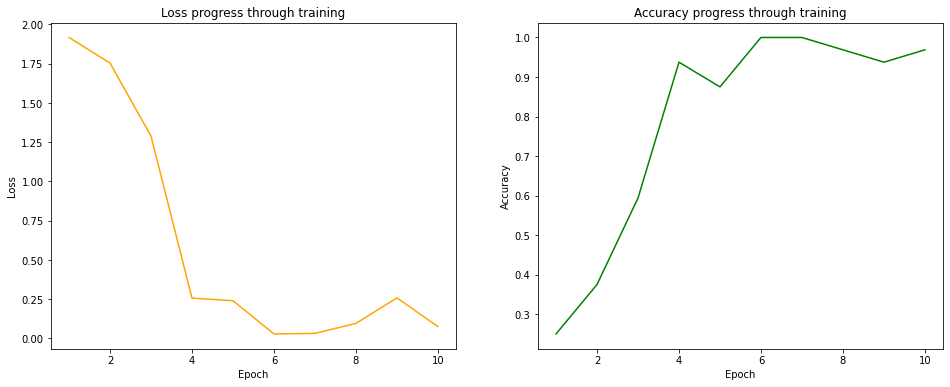

In [ ]:
# Plotting the losses and accuracies 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

ax[0].plot(range(1, len(loss_hist) + 1), loss_hist, c = 'orange')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss progress through training')

ax[1].plot(range(1, len(acc_hist) + 1), acc_hist, c = 'green')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy progress through training')

plt.show()

In [ ]:
def evaluate(model, test_loader):
    '''
    Returns the accuracy and loss of a model
    
    Parameters
    --------------
    model: A PyTorch neural network
    
    test_loader: The test dataset in the form of torch DataLoader
    '''
    model.eval()
    num_test_batches = len(test_loader)
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss = 0
        for i, batch in enumerate(test_loader):
            inputs, labels = batch
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim = 1)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Printing progress
            drawProgressBar((i+1), num_test_batches)
        
        accuracy = correct/total
        test_loss = total_loss/num_test_batches
    
    return accuracy, test_loss

In [ ]:
val_acc, val_loss = evaluate(net, val_loader)

print("\n\nValidation accuracy: {:.4f}".format(round(val_acc, 4)))
print("Validation loss: {:.4f}".format(round(val_loss, 4)))

Progress: [====================] 44/44

Validation accuracy: 0.1729
Validation loss: 6.4829


# Training a Convolutional neural network on spectrogram images

In [ ]:
# Checking the sample rate of the audio files in train and validation sets
set(train_sr), set(val_sr)

({22050}, {22050})

In [ ]:
train_sr = 22050
val_sr = 22050

def get_spec_loader(audio_time_series, sr, batch_size, shuffle = False):
    '''
    Returns data loader of spectrogram images
    
    Parameters
    ------------
    audio_time_series: Tensor Dataset with wav, label iterables
    
    sr: Sample rate
    
    batch_size: The batch size of data loader
    '''
    audio_spec_img = []
    labels = []
    curr = 0
    tot = len(audio_time_series)

    for wav, label in audio_time_series:
        spec_img = spec_to_image(get_melspectrogram_db(wav.numpy(), sr))
        spec_img = np.expand_dims(spec_img, axis = 0)
        audio_spec_img.append(spec_img)
        labels.append(label)

        curr += 1
        drawProgressBar(curr, tot, barLen = 40)

    audio_spec_img = torch.Tensor(audio_spec_img)
    audio_spec_img = audio_spec_img / 255
    
    labels = torch.Tensor(labels).long()

    audio_spec_img = data_utils.TensorDataset(audio_spec_img, labels)
    audio_loader = data_utils.DataLoader(audio_spec_img, batch_size = batch_size, shuffle = shuffle)
    
    return audio_loader

In [ ]:
# Getting the spectrogram image for each audio in train set
train_loader = get_spec_loader(train_time_series, train_sr, BATCH_SIZE, shuffle = True)

Progress: [========================================] 5600/5600

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [ ]:
# Getting the spectrogram image for each audio in validation set
val_loader = get_spec_loader(val_time_series, val_sr, BATCH_SIZE)

Progress: [========================================] 1400/1400

## Model cnn

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # Layer 1, Input shape (1, 128, 173) ->  Output shape (8, 62, 84)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (5, 6)), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = (2, 2)))
        
        # Layer 2, Input shape (8, 62, 84) -> Output shape (16, 30, 41)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3)), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = (2, 2)))
        
        # Layer 3, Input shape (16, 30, 41) -> Output shape (64, 10, 15)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (6, 7)), 
            nn.ReLU(), 
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (6, 6)), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = (2, 2)))
        
        # Fully Connected layer 1, Input features 64 * 10 * 15 -> Output features 512
        self.fc1 = nn.Linear(in_features = 64 * 10 * 15, out_features = 512)
        
        # Fully Connected layer 2, Input features 512 -> Output features 256
        self.fc2 = nn.Linear(in_features = 512, out_features = 256)
        
        # Fully Connected layer 3, Input features 256 -> Output features 128
        self.fc3 = nn.Linear(in_features = 256, out_features = 128)
        
        # Fully Connected layer 4, Input features 128 -> Output features 7
        self.fc4 = nn.Linear(in_features = 128, out_features = NUM_CLASSES)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.view(-1, self.num_flat_features(x))
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        n_features = 1
        for s in size:
            n_features = n_features * s
        
        return n_features

In [ ]:
# Defining loss and optimizer
NUM_CLASSES = len(classes)
LEARNING_RATE = 0.001
model = ConvNet()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
THRESHOLD = 0.001  # Threshold for early stopping
THRESH_EPOCHS = 3 # Number of epochs loss does not decrease before early stopping
PATH = './ConvNet.pth.tar'  # Path to save the best model
EPOCHS = 500

loss_hist = []
acc_hist = []
num_train_batches = len(train_loader)

early_stop_epoch = 0
lowest_loss = np.inf

for epoch in range(EPOCHS):
    print("Epoch " + str(epoch + 1) + ":")
    
    for i, batch in enumerate(train_loader):
        # batch is a tuple of data and labels
        data, labels = batch
        
        # Running forward pass
        outputs = model(data)
        loss = loss_fn(outputs, labels)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Measuring accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs, dim = 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / total
        
        # Printing progress
        drawProgressBar((i + 1), num_train_batches, 
                              '\t loss: {:.4f} \t acc: {:.4f}'.format(round(loss.item(), 4), round(accuracy, 4)))
    
    print('\n')
    
    if abs(lowest_loss - loss.item()) < THRESHOLD:
        early_stop_epoch += 1
        print('Loss did not decrease from ' + str(lowest_loss))
    
    else:
        print('Loss decreased from {:.4f} to {:.4f}, saving model to {}'.format(
            round(lowest_loss, 4), round(loss.item(), 4), PATH))
        
        lowest_loss = loss.item()
        early_stop_epoch = 0
        torch.save({'state_dict': model.state_dict()}, PATH)
        
    acc_hist.append(accuracy)
    loss_hist.append(loss.item())
    print('\n\n')

Epoch 1:
Progress: [====================] 88/88	 loss: 1.7301 	 acc: 0.2500

Loss decreased from inf to 1.7301, saving model to ./ConvNet.pth.tar



Epoch 2:
Progress: [====================] 88/88	 loss: 1.7514 	 acc: 0.2500

Loss decreased from 1.7301 to 1.7514, saving model to ./ConvNet.pth.tar



Epoch 3:
Progress: [====================] 88/88	 loss: 1.4318 	 acc: 0.4062

Loss decreased from 1.7514 to 1.4318, saving model to ./ConvNet.pth.tar



Epoch 4:
Progress: [====================] 88/88	 loss: 1.2706 	 acc: 0.5625

Loss decreased from 1.4318 to 1.2706, saving model to ./ConvNet.pth.tar



Epoch 5:
Progress: [====================] 88/88	 loss: 1.3457 	 acc: 0.5312

Loss decreased from 1.2706 to 1.3457, saving model to ./ConvNet.pth.tar



Epoch 6:
Progress: [====================] 88/88	 loss: 0.9895 	 acc: 0.5938

Loss decreased from 1.3457 to 0.9895, saving model to ./ConvNet.pth.tar



Epoch 7:
Progress: [====================] 88/88	 loss: 1.1547 	 acc: 0.6250

Loss decreased

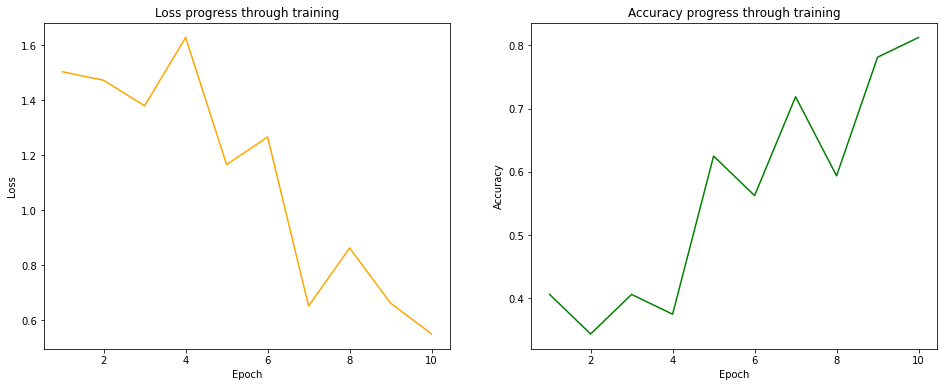

In [ ]:
# Plotting the losses and accuracies 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

ax[0].plot(range(1, len(loss_hist) + 1), loss_hist, c = 'orange')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss progress through training')

ax[1].plot(range(1, len(acc_hist) + 1), acc_hist, c = 'green')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy progress through training')

plt.show()

In [ ]:
# Loading the best model
model = ConvNet()
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
# Getting the validation accuracy and loss
val_acc, val_loss = evaluate(model, val_loader)

print("\n\nValidation accuracy: {:.4f}".format(round(val_acc, 4)))
print("Validation loss: {:.4f}".format(round(val_loss, 4)))

Progress: [====================] 44/44

Validation accuracy: 0.6536
Validation loss: 0.9714
